<a href="https://colab.research.google.com/github/lorenzflow/Portfolio/blob/main/Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of a citation network

## 1

In [ ]:
# basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier


# networkx
import networkx as nx
import csv
from operator import itemgetter
import community
%matplotlib inline



import warnings
warnings.filterwarnings("ignore")

# Pytorch
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

# sklearn supervised learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

# make plots nicer
sns.set()

# import data for task 1
feature_mat = pd.read_csv("/content/drive/My Drive/Data Science Coursework 3/feature_matrix.csv", header=None)
adjacency_mat = pd.read_csv("/content/drive/My Drive/Data Science Coursework 3/adjacency_matrix.csv")

In [ ]:
feature_mat.shape

(2485, 1434)

Text(0.5, 1.0, 'Data in 2-d after PCA')

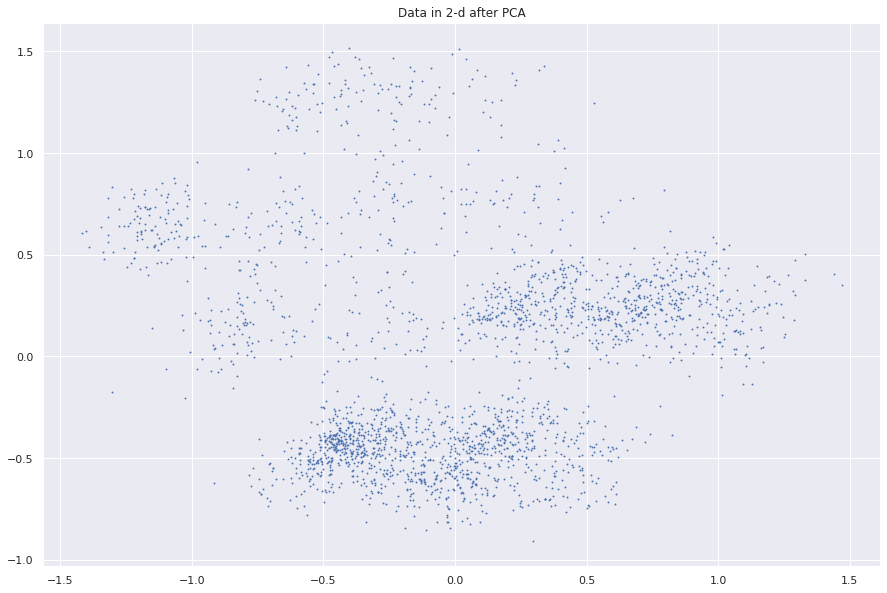

In [ ]:
# perform an initial PCA to visualise the data in 2-d
# reducing data to 2-d with PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(feature_mat.values)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = principalDf
# plotting reduced data
plt.figure(figsize = (15,10))
plt.scatter(finalDf['principal component 1'],finalDf['principal component 2'], zorder=10, s=0.8)
plt.title('Data in 2-d after PCA')





We might already guess some of the clusters based on this plot. After a quick first visualisation to get a rough overview of the data let us dive into the task.

### 1.1

In this task we will use the K-means algorithm to cluster the data. The algorithm tries to split the data into k groups of equal variance while minimising the within-cluster sum-of-squares.

The within-cluster sum-of-squares is defined in the following way:

$$\sum_{i=0}^N \underset{\mu_j \in C}{min}(\parallel x_i-\mu_j\parallel^2)$$

where we have disjoint clusters C, each with corresponding centroid $c_j$ (mean of samples in the cluster), and samples $\{x_i\}_{i=0}^N$

In [ ]:
# function to do kmeans with n clusters
def kmeans_cluster(n, X):

  # fit the model
  kmeans = KMeans(n_clusters=n, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=10, n_jobs=-1)
  labels = kmeans.fit_predict(X)
  # return score
  return calinski_harabasz_score(X,labels)

In [ ]:
k = range(2,31)
ch_scores = []
for n in k:
  ch_scores.append(kmeans_cluster(n,feature_mat))

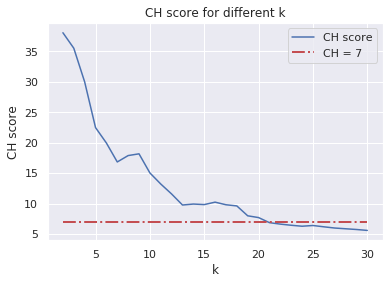

In [ ]:
out = pd.DataFrame(data={'ch_score':ch_scores, 'k':range(2,31)})
plt.plot(out['k'], out['ch_score'], label='CH score')
plt.title('CH score for different k')
plt.xlabel('k')
plt.ylabel('CH score')
plt.plot(out['k'], [7]*29, '-.', lw=2, color='r',label='CH = 7')
plt.legend()

In [ ]:
out[out['ch_score']<7]

,ch_score,k
19,6.877653,21
20,6.638665,22
21,6.452084,23
22,6.293422,24
23,6.412608,25
24,6.198673,26
25,5.997398,27
26,5.877085,28
27,5.758252,29
28,5.605940,30


We find that the first clustering with a CH-score < 7 is obtained with k=21. Hence we will use this as our optimal clustering.

Now let us analyse this clustering further:

In [ ]:
km_optimal = KMeans(n_clusters=21, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=10, n_jobs=-1)
labels = km_optimal.fit_predict(feature_mat)

# report cluster size
categories = np.unique(labels)
count = []

for i in categories:
  count.append(len(labels[labels==i]))
print('The cluster sizes are:',count)
print('Inertia:',km_optimal.inertia_)


The cluster sizes are: [1, 1, 790, 301, 1, 1, 107, 1, 1, 1, 3, 1, 4, 133, 380, 3, 81, 1, 672, 1, 1]
Inertia: 40524.72737485286


In [ ]:
# Which ones are the big and which ones the small clusters
small_clusters = categories[np.array(count)<50]
large_clusters = categories[np.array(count)>50]
print('The the small clusters are:',small_clusters)
print('The large cluster are:', large_clusters)

The the small clusters are: [ 0  1  4  5  7  8  9 10 11 12 15 17 19 20]
The large cluster are: [ 2  3  6 13 14 16 18]


(array([  1.,   1., 790., 301.,   1.,   1., 107.,   1.,   1.,   1.,   3.,
          1.,   4., 133., 380.,   3.,  81.,   1., 672.,   2.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20], dtype=int32),
 <a list of 20 Patch objects>)

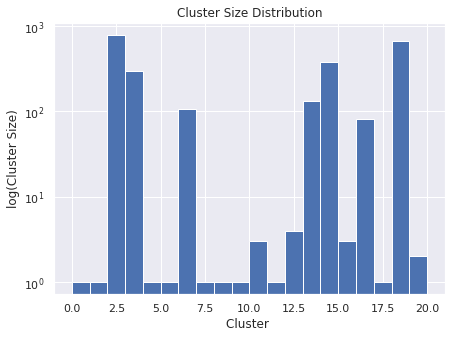

In [ ]:
# plot distribution of cluster sizes
plt.figure(figsize=(7,5))
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster ')
plt.ylabel('log(Cluster Size)')
plt.yscale('log')
plt.hist(labels, bins=categories)

In [ ]:
count = np.array(count)
print('Percentage of data contained in 7 main clusters:',count[large_clusters].sum()/2485)

Percentage of data contained in 7 main clusters: 0.9915492957746479


We see that the the range of cluster sizes is large, with the smallest ones containing only 1 data point and the largest one containing 790 data points which corresponds to approximately 32% of all data points. Overall we observe that almost all the data (99.15%) is concentrated in 7 clusters. This could indicate that we have some outliers in our data set. Let's investigate further by looking at the within and between cluster distances.

I will use two different distances/ similarity measures:
1. Euclidean Distance
2. $d(x^{(1)},x^{(2)}) = \sum_{l=1}^{1434} |x^{(1)}_l-x^{(2)}_l|$

The second distance simply looks at the number of different words contained in two papers. I want to use this distance  as it seems more appropriate considering the fact that we have binary data.

In [ ]:
# compute within-cluster and between cluster sum of euclidean distances
# normalised results by dividing by the number of points considered 
# to account for different cluster sizes
km_optimal_df = feature_mat
km_optimal_df['Labels'] = labels

centroids = km_optimal.cluster_centers_
cluster_distance_mat = np.zeros((21,21))
for i in categories:
  for j in categories:
    category_df = km_optimal_df[km_optimal_df['Labels']==i]
    category_df = category_df.drop('Labels', axis=1)
    cluster_distance_mat[i,j] = category_df.apply(lambda x: np.linalg.norm(np.subtract(np.array(x),centroids[j,:]))  ,axis=1).mean(axis=0)


Within Cluster Sum of Distances:
[0.00000000e+00 0.00000000e+00 3.93465084e+00 3.99953189e+00
 0.00000000e+00 0.00000000e+00 3.48301696e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.15277285e+00 0.00000000e+00
 1.72146971e+00 4.09267221e+00 4.05884889e+00 3.54199143e-16
 4.03701347e+00 0.00000000e+00 4.04879759e+00 0.00000000e+00
 0.00000000e+00]


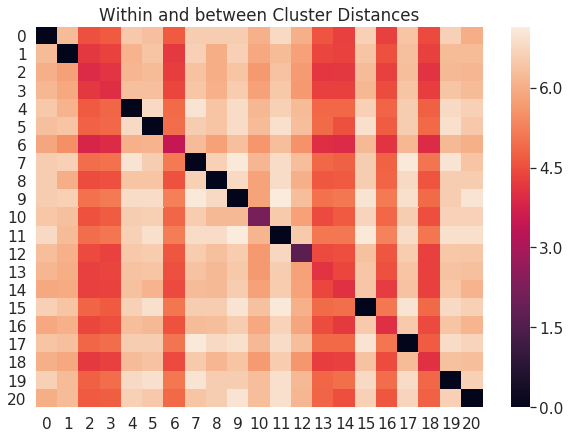

In [ ]:
print('Within Cluster Sum of Distances:')
print(cluster_distance_mat.diagonal())
plt.figure(figsize=(10,7))
plt.title('Within and between Cluster Distances')
sns.heatmap(pd.DataFrame(cluster_distance_mat))

For most clusters we can observe a clear difference between the within cluster sum of distances and the between-cluster sum of distances with the first one being smaller than the latter. It is interesting to see that for the clusters containing a very small number of data points the between-cluster distances are not large. This means we reject the hypothesis of there existing extreme outliers in our data set. This being not the reason for the large discrepancies in cluster sizes it seems likely that the obtained clustering is relatively poor. Furthermore, it suggests that we might want to compare the obtained clustering to a kmeans clustering with a reduced number of clusters (7 would be my first attempt based on the cluster size distribution).

We can also identified possible bad clusters with a roughly equal within-cluster similarity and between-cluster similarity. Namely the clusters 2,3,13,14,18, and maybe also 6.

In [ ]:
# compute within-cluster and between cluster sum of differences
# we normalise the final result by deviding through the number of points and
# the number of features corresponding to the maximal difference
centroids = km_optimal.cluster_centers_
cluster_distance_mat = np.zeros((21,21))
for i in categories:
  for j in categories:
    category_df = km_optimal_df[km_optimal_df['Labels']==i]
    category_df = category_df.drop('Labels', axis=1)
    cluster_distance_mat[i,j] = category_df.apply(lambda x: np.sum(np.absolute(np.subtract(np.array(x),centroids[j,:])))  ,axis=1).mean(axis=0)/1434


Within Cluster Sum of Differences:
[0.00000000e+00 0.00000000e+00 2.25850893e-02 2.30444715e-02
 0.00000000e+00 0.00000000e+00 1.78963575e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.81853402e-03 0.00000000e+00
 4.61994421e-03 2.39354797e-02 2.35394090e-02 6.88929581e-19
 2.30400807e-02 0.00000000e+00 2.35011161e-02 0.00000000e+00
 0.00000000e+00]


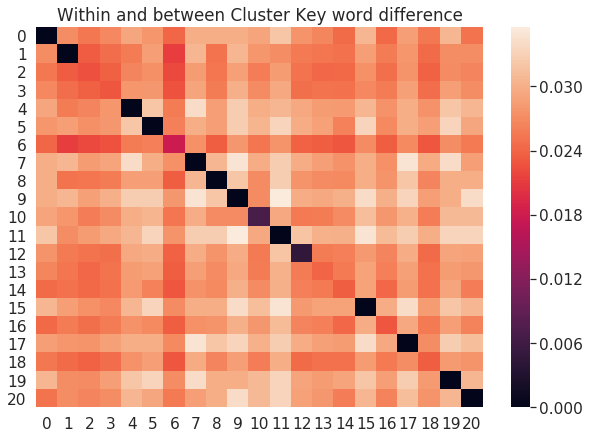

In [ ]:
# show results
print('Within Cluster Sum of Differences:')
print(cluster_distance_mat.diagonal())
plt.figure(figsize=(10,7))
plt.title('Within and between Cluster Key word difference')
sns.heatmap(pd.DataFrame(cluster_distance_mat))

This measure displays shows similar results and we can identify the same problem areas. One key difference appears to be that between-cluster distances from all other clusters to the centroids of the problematic clusters do not stand out from the rest as before.

#### Discussion of the CH score

The Calinski-Harabasz score is defined by $$CH_k = \frac{S_B}{S_W}\frac{N-k}{k-1}$$ where k is the number of clusters and $S_B$ and $S_W$ are the overall between- and overall within-cluster variance respectively. 

The overall between-cluster variance $S_B$ defined by $S_B = \sum_{i=1}^k n_i \parallel m_i-m\parallel^2$ with k the number of clusters, $n_i$ the number of observations in cluster i, $m_i$ the centroid of cluster i and m the mean of the whole data.

The overall within-cluster variance $S_W$ is defined by $S_W = \sum_{i=1}^k\sum_{x\in C_i} \parallel x-m_i\parallel^2$ with k the number of clusters and $C_i$ the ith cluster with centroid $m_i$.

In general a high CH score indicates a good clustering since we then have a large between-cluster variance and a in comparison small within-cluster variance.

However, we do not just want to pick the clustering with the highest CH score since this would be a very low number of clusters and very unlikely to represent the data well. This is due to the fact that for small k the factor $\frac{N-k}{k-1}$ is large. To accomodate for the increase of the CH score with decreasing number of clusters we set a threshold of 7.



#### Comparison to other metrics

1. Silhouette Score 
2. Davies Boulding Index

The Silhouette score of a sample is defined by $\frac{b-a}{max(a,b)}$ where a is the mean intra cluster distance and b the mean nearest-cluster distance (distance to the nearest cluster that the sample is not part of). For a good clustering we would like b to be large and a to be small. Hence this measure has a range from -1 to 1 where 1 corresponds to the best and -1 to the worst possible score. 

The in sklearn implemented Davies Bouldin Score is defined as the average similarity measure of each cluster with its most similar cluster. Here similarity is the ratio of within-cluster distances to between-cluster distances. This means that clusters which are further apart and less dispersed will result in a lower score, with the best score being 0.

In [ ]:
# Silhouette Coefficient
print('Silhouette score of the optimal clustering:', silhouette_score(feature_mat, labels, metric='euclidean'))

Silhouette score of the optimal clustering: 0.024850093245365613


In [ ]:
# Davies Bouldin Score
davies_bouldin_score(feature_mat, labels)

5.283398601540272

A Silhouette score of 0.055 is not great and since it is close to 0 indicates either that we have a lot of overlap between clusters or that many points are close to the cluster boundaries.

The Davies Bouldin Score is of this model is itself is hard to interpret since it is relative.

Let us compute the whole range of Silhouette scores and davies boulding scores:

In [ ]:
k = range(2,31)
db_scores = []
sh_scores = []
for n in k:
  kmeans = KMeans(n_clusters=n, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=10, n_jobs=-1)
  labels = kmeans.fit_predict(feature_mat)
  db_scores.append(davies_bouldin_score(feature_mat,labels))
  sh_scores.append(silhouette_score(feature_mat,labels))
  print(n)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


Text(0, 0.5, 'Score')

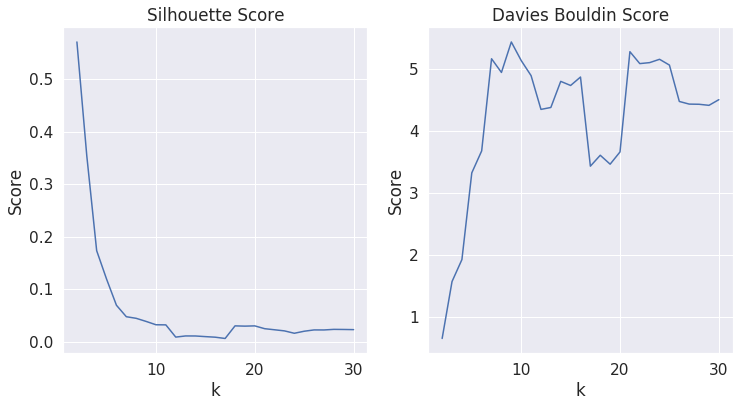

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.plot(np.arange(2,31), sh_scores)
ax1.set_title('Silhouette Score')
ax1.set_xlabel('k')
ax1.set_ylabel('Score')

ax2.plot(np.arange(2,31), db_scores)
ax2.set_title('Davies Bouldin Score')
ax2.set_xlabel('k')
ax2.set_ylabel('Score')

This plots show us that both according to the silhouette score and the davies bouldin score this clustering is not optimal, since for the applying the elbow method to the silhouette score plot yields a value below 10 and according to the plot of the davies bouldin score a clustering with k = 17,18,19, or 20 would be better.

**Evaluating the randomness of result**

To ecaluate the randomness of my results I will run the kmeans algorithm several times (without a fixed random state) and study how the k choosen as optimal number of clusters varies.



In [ ]:
def ch_randomness(rand_states, X):
  # fit the model
  ch_scores = []
  for i in rand_states:
    kmeans = KMeans(n_clusters=21, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=i, n_jobs=-1)
    labels = kmeans.fit_predict(X)
    ch_scores.append(calinski_harabasz_score(X,labels))

  return ch_scores

In [ ]:
ch_scores = []
ch_scores = ch_randomness(np.arange(0, 100), feature_mat)

Text(0, 0.5, 'CH score')

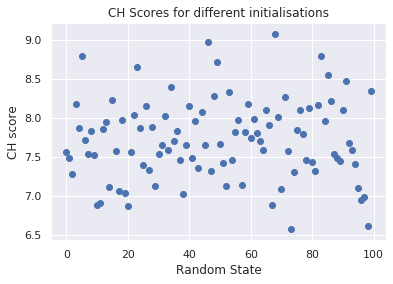

In [ ]:
plt.scatter(np.arange(0, 100), np.array(ch_scores))
plt.title('CH Scores for different initialisations')
plt.xlabel('Random State')
plt.ylabel('CH score')

In [ ]:
ch_scores = np.array(ch_scores)
print('The mean of the computed CH scores is:',np.mean(ch_scores))
print('The standard deviation of the computed CH scores is:', np.sqrt(ch_scores.var()))
print('Percentage of values below 7:', len(ch_scores[ch_scores<7]), '%')

The mean of the computed CH scores is: 7.7186087635176275
The standard deviation of the computed CH scores is: 0.5086185191387685
Percentage of values below 7: 8 %


In the above plot we can observe that in the 100 different runs of kmeans with k=21 we have quite a spread in the CH scores. Overall the mean is 7.72,which is not very close to 7 , and a standard deviation of 0.51. This spread is due to the randomness of the kmeans which is inherited from the initalisation of the centroids. Only 8% of the computed values lie below 7, giving evidence for our result being not very robust.

### 1.2

In this task we will use NetworkX to first plot the citation graph described by the adjacency matrix and then taking a closer look at properties of the graph by plotting the degree distribution and analysing the centrality of nodes. This will be done by looking at the centrality measures degree, betweenness centrality and pagerank. Finally I will investigate the correlation between those different measures.

In [ ]:
# load the data
adjacency_mat1 = np.loadtxt("/content/drive/My Drive/Data Science Coursework 3/adjacency_matrix.csv", delimiter=',')

In [ ]:
# initialise graph object
G = nx.Graph(adjacency_mat1)
pos = nx.spring_layout(G,iterations=100)

In [ ]:
# quickly check if graph is connected
nx.is_connected(G)

True

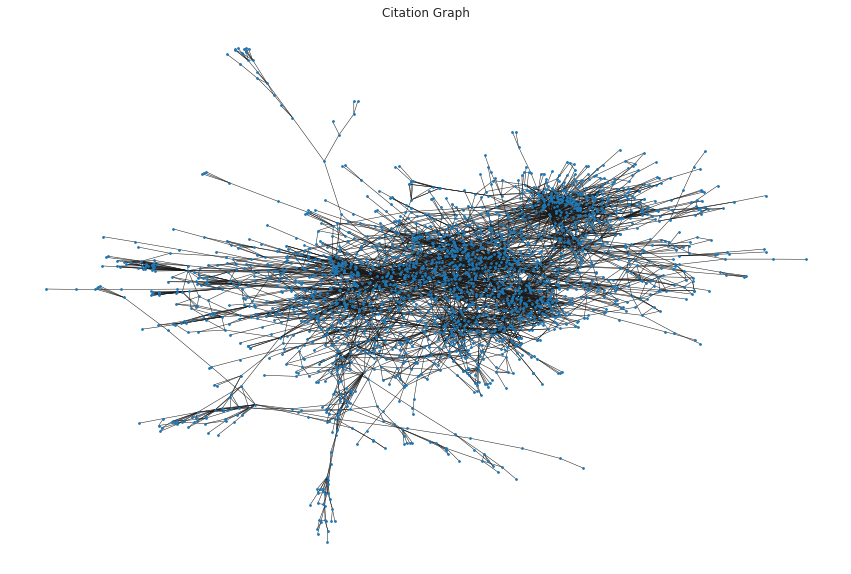

In [ ]:
# plot citation graph
plt.figure(figsize=(15,10)) 
plt.title('Citation Graph')
nx.draw(G,pos ,node_size=3, width=0.5)

Since it is hard to observe any properties of the graph just from this plot, let us analyse the centrality of the nodes.

#### Degree Distribution

First we will look at the degree of a node v, which is the number of edges connected to v.

In [ ]:
# computing degrees and adding them as attributes to graph
degrees = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degrees, 'degree')

Text(0, 0.5, 'Frequency')

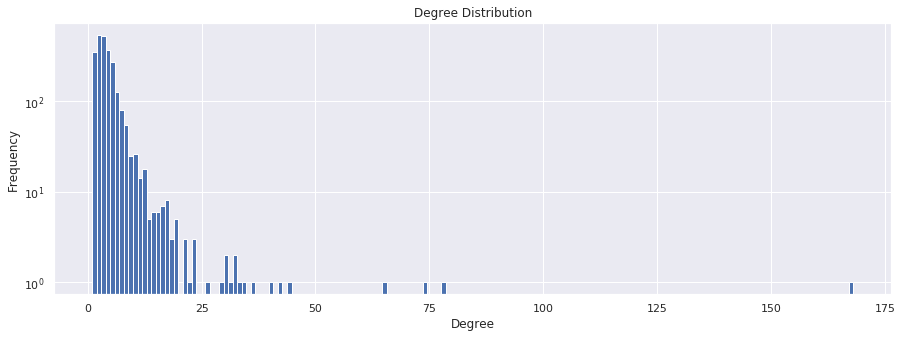

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(list(degrees.values()), bins=max(list(degrees.values()))-min(list(degrees.values()))+1, color='b')
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.yscale('log')
plt.ylabel('Frequency')

We can observe that the majority of nodes has a low degree, however there exists a significant 'tail' to the distribution corresponding to nodes with degree as large as 168.

According to literature such a distribution is commonly found in graphs describing a citation network.

To take this analysis a step further, let us have a quick look at whether the degree distribution follows a power-law distribution.

For this we plot the distribution on a log-log scale and use logarithmic binning to make the bins look of same size on the logscale and we account for the noise introduced by the decreasing number of obsercations for larger degrees. In general the n-th bin will cover the interval $2^{n-1}\leq d < 2^{n}$ (last bin is cut at 168 since this is highest degree)

________________________________

Text(0, 0.5, 'Frequency')

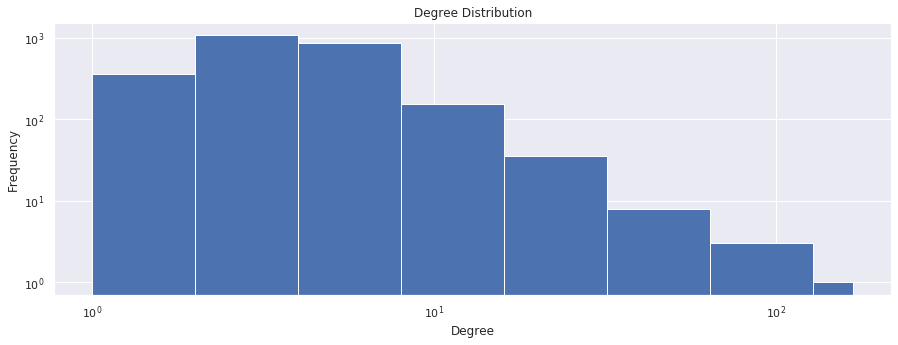

In [ ]:
m = list(np.arange(0,8))
m = [2**x for x in m]
m.append(168)
m

plt.figure(figsize=(15,5))
plt.hist(list(degrees.values()), bins=m)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Frequency')

We can observe that for higher degrees the degree distribution follows a power law since we can fit a straight line. If the degree distribution follows a power law there are some interesting properties we know about the network. We will not go into detail in this coursework, but refer to 'Networks an Introduction' by M. E. J. Newman.

#### Centrality Measures
The **degree centrality** of a node v is defined by $$c_D(v) = \frac{d_v}{n-1}$$ where $d_v$ is the degree of node v and n is the total number of nodes in the network, i.e n-1 is the maximal degree possible. For a citation network of papers especially the in-degree centrality corresponding to the number of citations a paper has received is an important measure of influence of a paper. Since we have an undirected graph we can not know whether the paper has high degree because it was cited many times or whether its authors cited many papers.

The **betweenness centrality** of a node v is defined by $$c_B(v) = \sum_{s,t \in V}\frac{\rho(s,t |v)}{\rho(s,t)}$$

where V is the set of nodes, $\rho(s,t)$ is the number of shortest (s,t)-paths, and $\rho(s,t|v)$ is the number of those paths passing through node v other than s,t.

If s=t, then $\rho(s,t)=1$ and if $v \in \{s,t\}$ then $\rho(s,t|v)=0$.

Hence the higher the betweenness centrality of a node v, the more of the shortest paths between any two nodes pass through v, indicating that v is important for the exchange of ideas i.e. flow of information/collaboration in the network and thus meaning it has high centrality.

The **Pagerank** is defined by the stationary eigenvector of $\overline{c}_{PR}=\alpha(AD^{-1})\overline{c}_{PR}+ (1-\alpha)\frac{\overline{1}}{N}$
Page rank is based on the edges being connected to a node.
Note that without constant term, i.e. $\alpha=1$ this corresponds to the degree.

In [ ]:
# computing degree centrality
dg_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, dg_centrality, 'degree_centrality')

In [ ]:
# computing betweenness centrality
bt_centrality = nx.betweenness_centrality(G)
nx.set_node_attributes(G, bt_centrality, 'betweenness_centrality')

In [ ]:
# computing pagerank
pagerank = nx.pagerank(G)
nx.set_node_attributes(G, pagerank, 'pagerank')

Text(0, 0.5, 'Pagerank')

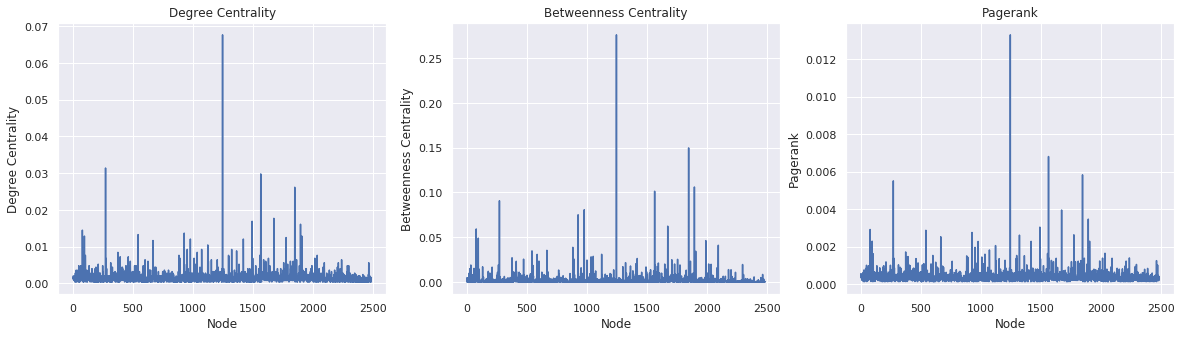

In [ ]:
# plot degree centrality
fig, ax=plt.subplots(1,3, figsize=(20,5))

ax[0].plot(list(dg_centrality.keys()), list(dg_centrality.values()))
ax[0].set_title('Degree Centrality')
ax[0].set_xlabel('Node')
ax[0].set_ylabel('Degree Centrality')

ax[1].plot(list(bt_centrality.keys()), list(bt_centrality.values()))
ax[1].set_title('Betweenness Centrality')
ax[1].set_xlabel('Node')
ax[1].set_ylabel('Betweenness Centrality')

ax[2].plot(list(pagerank.keys()), list(pagerank.values()))
ax[2].set_title('Pagerank')
ax[2].set_xlabel('Node')
ax[2].set_ylabel('Pagerank')

These plots of centrality measure vs node give us an idea of which nodes stand out from the rest. there seems to be one node with a particularly high score in all centrality measures. For degree centrality and pagerank I suggest to consider the top 4 nodes as very central since these seem to have a significantly higher score than all others while still being a small set of nodes. According to betweenness centrality it looks like a good cut-off point is after the top 7.

Let us take a look at which those nodes are.

In [ ]:
# print top 4 pairs for degree centrality
top_degree = dict(sorted(dg_centrality.items(), key = itemgetter(1), reverse = True)[:4])

In [ ]:
# print top 7 pairs for betweenness centrality
top_btc = dict(sorted(bt_centrality.items(), key = itemgetter(1), reverse = True)[:7])

In [ ]:
# print top 4 pairs for pagerank
top_pagerank = dict(sorted(pagerank.items(), key = itemgetter(1), reverse = True)[:4])

In [ ]:
top_degree_df = pd.DataFrame(list(top_degree.items() ), columns=['Node', 'Degree Centrality'])
print(top_degree_df)

   Node  Degree Centrality
0  1245           0.067633
1   271           0.031401
2  1563           0.029791
3  1846           0.026167


In [ ]:
print(pd.DataFrame(list(top_btc.items() ), columns=['Node', 'betweenness centrality']))

   Node  betweenness centrality
0  1245                0.276114
1  1846                0.149763
2  1894                0.106109
3  1563                0.101355
4   271                0.090707
5   977                0.080662
6   926                0.075044


In [ ]:
top_pagerank_df = pd.DataFrame(list(top_pagerank.items() ), columns=['Node', 'pagerank'])
print(top_pagerank_df)

   Node  pagerank
0  1245  0.013302
1  1563  0.006811
2  1846  0.005833
3   271  0.005511


Taking all 3 centrality measures into account we can conclude that node 1245 is highly central, as it has a significantly higher score than all other nodes.

Interestingly, according to pagerank and degree centrality we regard the same top 4 nodes as central (in slightly different order).  

Next let us investigate the similarities and differences between those three centrality measures:

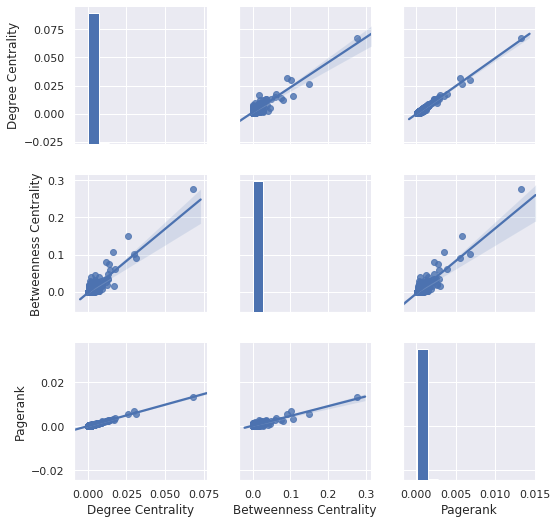

In [ ]:
# Correlation plots of the centrality measures
sns.set()
dict = {'Degree Centrality':list(dg_centrality.values()), 'Betweenness Centrality':list(bt_centrality.values()), 'Pagerank':list(pagerank.values()) }
data = pd.DataFrame(dict)
sns.pairplot(data, kind='reg')

It seems like there is a strong correlation between all three. To obtain a better insight into how these measures are correlated with each other let us scale them to the same range between 0 and 1.

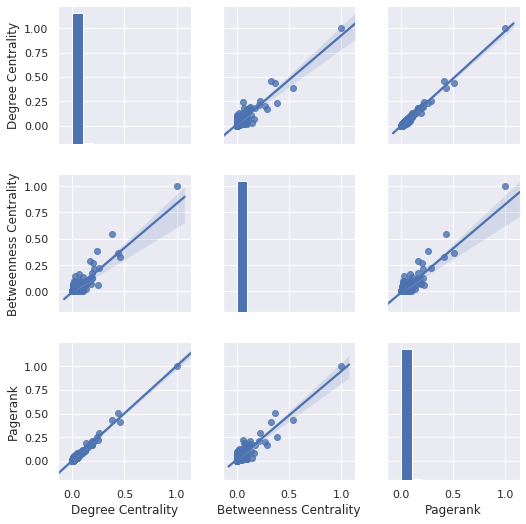

In [ ]:
# let us now scale all 3 measures to the same range between 0 and 1
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(data)
data_scaled = pd.DataFrame(scaler.transform(data), columns = data.columns)
sns.pairplot(data_scaled, kind='reg')

Now that we have scaled the data the correlation plots are better to interpret. We find that the correlation between betweenness-centrality and pagerank as well as between betweenness centrality and degree centrality is significantly lower than the correlation between degree centrality and pagerank. Finally let's remove the node 1245 from the data as it appears to be an extrem outlier.

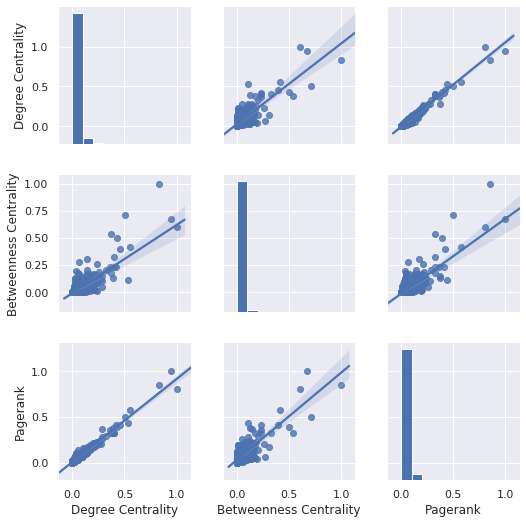

In [ ]:
# now exclude the outlier node 1245
data_dropped = data.drop(data.index[[1245]])
# could exclude more outliers but leave it at that since this is the main one 
# possible others: , 271, 1563, 1846, 1672, 1894, 977, 926
scaler = preprocessing.MinMaxScaler()
scaler.fit(data_dropped)
data_scaled = pd.DataFrame(scaler.transform(data_dropped), columns = data.columns)
sns.pairplot(data_scaled, kind='reg')

In the above correlation plots we can observe that for our network a strong correlation between Degree and Pagerank exists. In particular note that this correlation is visible for all values of degree/pagerank, from low to high and is not strongly influenced by the few nodes with higher degree. This is caused by the similar methodology of both measures being based on the edges connected to a node. Note that Pagerank without an additive constant for undirected network gives just degree centrality.

Now considering the scatter plots of betweenness centrality against degree centrality or pagerank. First we observe that the correlation is much lower than the one between pagerank and degree centrality. On the first glance it also looks like the regression line is mainly pulled up by the few values with higher degree/pagerank while for lower degrees we can observe a more blob-like shape, i.e. weak to no correlation. This observation is supported by the fact that after removing the node 1245, the regression lines for betweenness centrality vs pagerank and betweenness centrality vs degree centrality are significantly flatter (drop from approximately 0.8 and 0.8 to 0.6 and 0.7 respectively) than when this outlier is included, while for degree centrality vs page rank there is no noticeable difference.

This difference between betweenness centrality and the other two finds its root in the definition as a node could have a high betweenness centrality (by for example connecting two communities) but be only connected to 2 other nodes. The undelying methodologies of measuring centrality are here quite different.

### 1.3 Community detection

Having used kmeans clustering on the feature matrix we will now turn to graph based clustering.

To identify the communities in the graph we will use the Clauset-Newman-Moore greedy modularity maximisation algorithm implemented in NetworkX. This algorithm starts with each node in an own community and then joins communities together in order to most increase modularity.

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(G))

In [ ]:
# plot citation graph
label = 0
# initialising dictionary to store node and cooresponding community label
colors = {}
# loop over communities
for i in c:
  # loop over nodes in communities and add entries to dictionary
  for j in i:
    colors[j] = label
  label = label+1


In [ ]:
# sort the node order
colors_sorted = {}
for i in sorted(colors):
  colors_sorted[i] = colors[i]

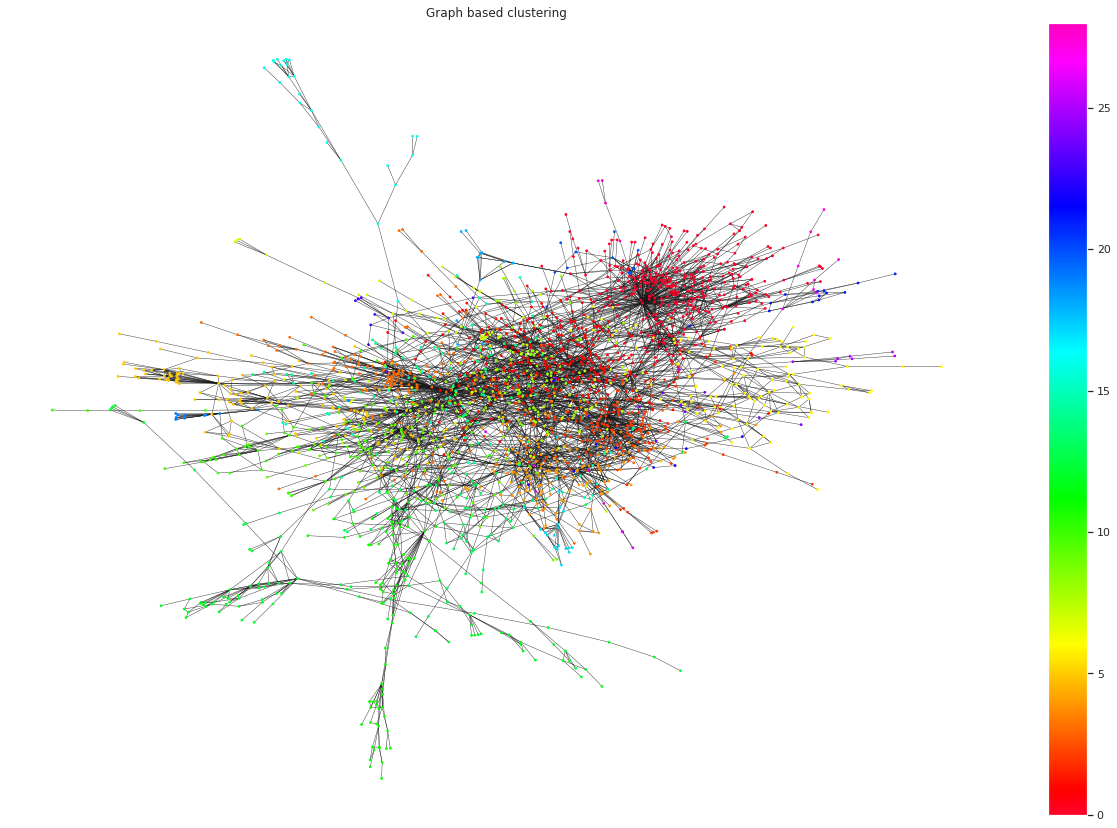

In [ ]:
# plot the graph with nodes colored by communities
plt.figure(figsize=(17,11))
cmap_initial=range(29)
cmap=plt.cm.gist_rainbow
vmin = min(cmap_initial)
vmax = max(cmap_initial)
nx.draw(G, pos,node_size=3, node_color=list(colors_sorted.values()), cmap=cmap,
           with_labels=False, vmin=vmin, vmax=vmax, width = 0.4)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)
plt.title('Graph based clustering')
plt.show()

#### Communities of central nodes

In this task I will look at how the top 30 most central nodes according to degree centrality and pagerank are distributed across the communities

In [ ]:
# community sizes
dummy = np.array(list(colors_sorted.values()))
unique_communities = np.unique(dummy)
community_sizes = []

for i in unique_communities:
  community_sizes.append(len(dummy[dummy==i]))

[391, 307, 199, 183, 166, 149, 115, 115, 114, 108, 102, 95, 92, 82, 71, 38, 25, 21, 13, 13, 13, 13, 11, 11, 9, 9, 8, 8, 4]


(array([391., 307., 199., 183., 166., 149., 115., 115., 114., 108., 102.,
         95.,  92.,  82.,  71.,  38.,  25.,  21.,  13.,  13.,  13.,  13.,
         11.,  11.,   9.,   9.,   8.,   8.,   4.]),
 array([ 0.        ,  0.96551724,  1.93103448,  2.89655172,  3.86206897,
         4.82758621,  5.79310345,  6.75862069,  7.72413793,  8.68965517,
         9.65517241, 10.62068966, 11.5862069 , 12.55172414, 13.51724138,
        14.48275862, 15.44827586, 16.4137931 , 17.37931034, 18.34482759,
        19.31034483, 20.27586207, 21.24137931, 22.20689655, 23.17241379,
        24.13793103, 25.10344828, 26.06896552, 27.03448276, 28.        ]),
 <a list of 29 Patch objects>)

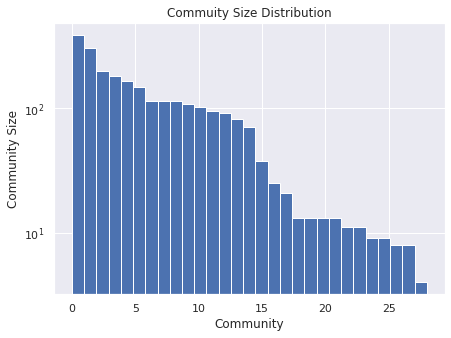

In [ ]:
# print the community sizes
bi = np.array(list(set(list(colors_sorted.values()))))
print(community_sizes)
plt.figure(figsize=(7,5))
plt.title('Commuity Size Distribution')
plt.xlabel('Community')
plt.yscale('log')
plt.ylabel('Community Size')

plt.hist(list(colors_sorted.values()), bins = np.argmax(bi)-np.argmin(bi)+1)

In the distribution of community sizes we observe a large spread. Furthermore the histogram shows that we have a larger number of small communities, a small number of large communities and a number in between of medium size communities.

Let us now compare the community and cluster size distributions:

(array([  1.,   1., 790., 301.,   1.,   1., 107.,   1.,   1.,   1.,   3.,
          1.,   4., 133., 380.,   3.,  81.,   1., 672.,   2.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20], dtype=int32),
 <a list of 20 Patch objects>)

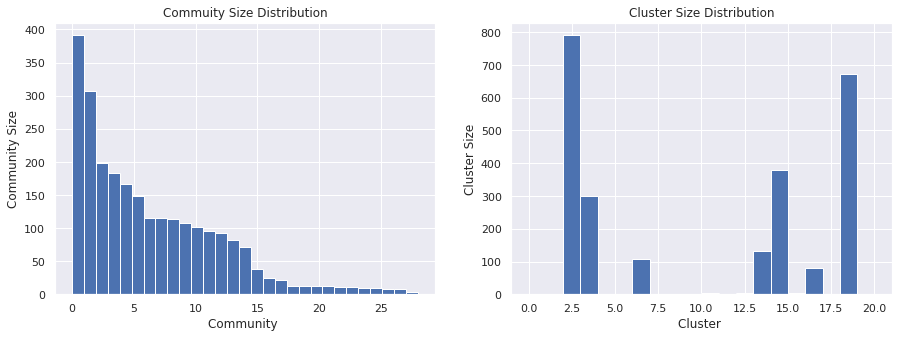

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

bi = np.array(list(set(list(colors_sorted.values()))))

ax1.set_title('Commuity Size Distribution')
ax1.set_xlabel('Community ')
ax1.set_ylabel('Community Size')

ax1.hist(list(colors_sorted.values()), bins = np.argmax(bi)-np.argmin(bi)+1)

ax2.set_title('Cluster Size Distribution')
ax2.set_xlabel('Cluster ')
ax2.set_ylabel('Cluster Size')
ax2.hist(labels, bins=categories)

We observe that with the graph based clustering the range and variance of community sizes is much smaller than for the k-means clusters. 

In [ ]:
# data frame with top 30 nodes according to degree centrality
top_degree30 = dict(sorted(dg_centrality.items(), key = itemgetter(1), reverse = True)[:30])
top_degree30_df = pd.DataFrame(list(top_degree30.items() ), columns=['Node', 'Degree Centrality'])

# finding clusters of top 30 nodes
degree_label = []
for i in top_degree30_df['Node']:
  degree_label.append(colors_sorted[i])

# adding column containing cluster to data frame
top_degree30_df['cluster'] = degree_label

print(top_degree30_df)

    Node  Degree Centrality  cluster
0   1245           0.067633        0
1    271           0.031401        2
2   1563           0.029791        3
3   1846           0.026167        3
4   1672           0.017713        5
5   1491           0.016908        2
6   1894           0.016103       10
7     78           0.014493        1
8    926           0.013688        1
9    542           0.013285        3
10    95           0.012882        2
11  1905           0.012882        2
12  1774           0.012480        1
13   977           0.012077        0
14  1418           0.012077        5
15   666           0.011675        9
16  1122           0.010467        1
17   951           0.009259        4
18  1071           0.009259        0
19  1321           0.009259        7
20  1362           0.008857        0
21    84           0.008454        4
22   374           0.008454        1
23  1034           0.008454        8
24   103           0.007649        1
25   882           0.007649       11
2

In [ ]:
# data frame with top 30 nodes according to pagerank
top_pagerank30 = dict(sorted(pagerank.items(), key = itemgetter(1), reverse = True)[:30])
top_pagerank30_df = pd.DataFrame(list(top_pagerank30.items() ), columns=['Node', 'Pagerank'])

# finding clusters of top 30 nodes
pagerank_label = []
for i in top_pagerank30_df['Node']:
  pagerank_label.append(colors_sorted[i])
# adding column containing cluster to data frame
top_pagerank30_df['cluster'] = pagerank_label

print(top_pagerank30_df)

    Node  Pagerank  cluster
0   1245  0.013302        0
1   1563  0.006811        3
2   1846  0.005833        3
3    271  0.005511        2
4   1672  0.003957        5
5   1894  0.003471       10
6   1491  0.003043        2
7     78  0.002917        1
8    542  0.002875        3
9    926  0.002759        1
10  1774  0.002633        1
11  1321  0.002616        7
12   666  0.002530        9
13  1905  0.002293        2
14    95  0.002292        2
15  1418  0.002285        5
16   977  0.002280        0
17  1122  0.002060        1
18   951  0.001965        4
19  1071  0.001825        0
20   374  0.001719        1
21  2033  0.001649        4
22  1555  0.001637        4
23   103  0.001624        1
24  1034  0.001600        8
25    84  0.001593        4
26   600  0.001534        7
27  1298  0.001532        4
28  1362  0.001519        0
29   882  0.001508       11


Text(0.5, 1.0, 'Distribution of top 30 nodes - Pagerank')

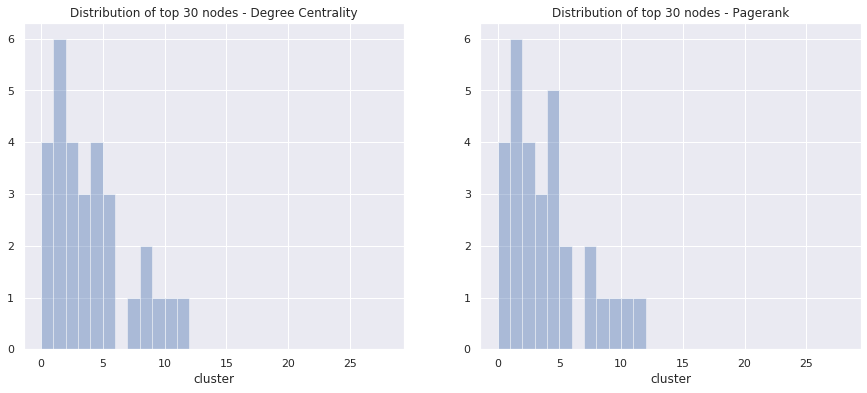

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

# plot how top 30 nodes according to degree centrality are distributed across the clusters
sns.distplot(top_degree30_df['cluster'], kde=False, bins= sorted(set(list(colors.values()))), ax=ax1)
ax1.set_title('Distribution of top 30 nodes - Degree Centrality')

# plot how top 30 nodes according to pagerank are distributed across the clusters
sns.distplot(top_pagerank30_df['cluster'], kde=False, bins= sorted(set(list(colors.values()))), ax=ax2)
ax2.set_title('Distribution of top 30 nodes - Pagerank')

First we observe that the distribution is very similar for both centrality measures. This is due to the high correlation between pagerank and degree centrality, which therefore pick up very similar nodes. 

We also find that all of the top 30 most central nodes are contained in only 11 clusters which have all a relatively large community size (except community 6 which has size 115 and doesn't contain any of the central nodes). The modularity is defined as the fraction of edges within the community minus the expected fraction of edges if they were distributed randomly and we compute the communities by maximising their modularity. Now this leads to nodes with high degree or pagerank being in larger communities leading to the observed distribution, where the larger communities contain a few highly central nodes, the medium large communities contain 1 or 2 central nodes and the small communities contain none.

This distribution is statistically quite likely, since it is in between the two extremes of having the top 30 nodes evenly distributed across the communities or having them all in one community.

### 1.4 cluster comparison

Let us now compare the clustering obtained with kmeans and the graph based communities. To do this we use the **Adjusted Rand Index** as well as the **Adjusted Mutual Information score**
.
Given a set S of n elements and two groupings or partitions namely $X=\{X_1, X_2, ...,X_r\}$ and $Y=\{Y_1, Y_2, ...,Y_s\}$, we define the following:
* a, number of pairs of elements in S that are in the same subset in X and the same subset in Y
* b, the number of pairs of elements in S that are in different subsets in X and in different subsets in Y
* c, the number of pairs of elements in S that are in the same subset in X and in different subsets in Y
* d the nbumber of pairs of elements inS that are in different subsets in X and in the same subsets in Y

Then the Rand index R is given by
$$R = \frac{a+b}{a+b+c+d}$$ 

We can interpret the rand index to represent the probability that X and Y will agree on a randomly chosen pair.

For the mutual information of the 2 partitions X and Y we assume that the clusters of each partition are pairwise disjoint and define:
* $P(i) = \frac{|X_i|}{n}$ and $P'(i)=\frac{Y_i}{n}$
* $H(X) = -\sum_{i=1}^r P(i)log(P(i))$ and similarly $H(Y) = -\sum_{i=1}^s P'(i)log(P'(i))$

Then the mutual information is given by:
$$MI(X,Y)=\sum_{i=1}^r\sum_{j=1}^sP(i,j)log\frac{P(i,j)}{P(i)P'(j)}$$ where $P(i,j)= \frac{|X_i\cap Y_j|}{n}$

MI is non-negative and bounded above by H(X) and H(Y). It measures the shared information by the two clusterings.

Now the adjusted mesures are adjusted for chance. We define $a_i$ = ith rowsum of contingency matrix [$n_{ij}$] (where $n_{ij}=|X_i\cap Y_j|$) and $b_j$= jth columnsum of contingency matrix
 Then the adjusted rand index ARI is defined by:
$$ARI(X,Y) = \frac{\sum_{ij}\binom{n_{ij}}{2}-\frac{[\sum_{i}\binom{a_{i}}{2}\sum_{j}\binom{b_{j}}{2}]}{\binom{n}{2}}}
{\frac{1}{2}[\sum_{i}\binom{a_{i}}{2}+\sum_{j}\binom{b_{j}}{2}]-\frac{[\sum_{i}\binom{a_{i}}{2}\sum_{j}\binom{b_{j}}{2}]}{\binom{n}{2}}}$$
The ARI is on a range of -1 to 1 where 1 corresponds to a perfect match between the clusters.

The adjusted mutual information score is defined by:

$$AMI(X,Y) = \frac{ MI(X,Y)-E(MI(X,Y))}{max(H(X),H(Y))- E(MI(X,Y))}$$

The AMI takes a value of 1 when the two partitions are identical and a value of 0 when the MI between the two partitions is what we would expect by chance.

In [ ]:
# adjusted rand index and AMI

print('ARI:',adjusted_rand_score(labels, list(colors_sorted.values())))
print('AMI:', adjusted_mutual_info_score(labels, list(colors_sorted.values())))

ARI: 0.05662578365279803
AMI: 0.11357314813789136


We obtain the AMI slightly larger than 0 indicating that the overlap is more than what we would expect by chance. The ARI as well slightly larger than 0 indicates similarly slightly more similarity than what is expected by chance.

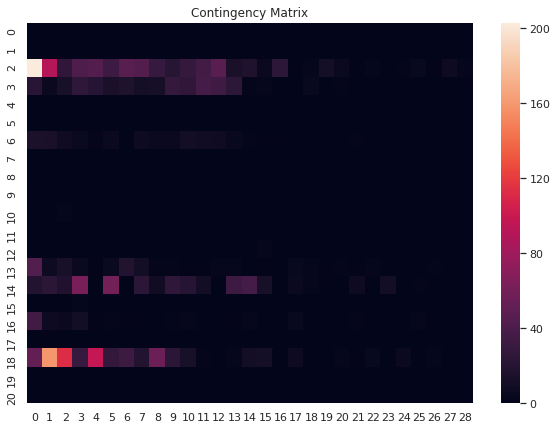

In [ ]:
# plot contingency matrix
from sklearn.metrics.cluster import contingency_matrix
contingency_matrix = contingency_matrix(labels, list(colors_sorted.values()))
plt.figure(figsize = (10,7))
plt.title('Contingency Matrix')

sns.heatmap(contingency_matrix)

The contingency matrix visualises the small overlap of the two clusterings nicely. However we need to be careful since this is partly due to the small cluster/community size for many of the clusters and communities. The clusters/communities with larger size have generally more overlap. Only the k_means cluster 2 has significant overlap with community 0 and some overlap with community 1. This is partly because cluster 2 is the largest cluster by far. We can also observe that cluster 18 has quite high overlap with communities 1,2, and 4.

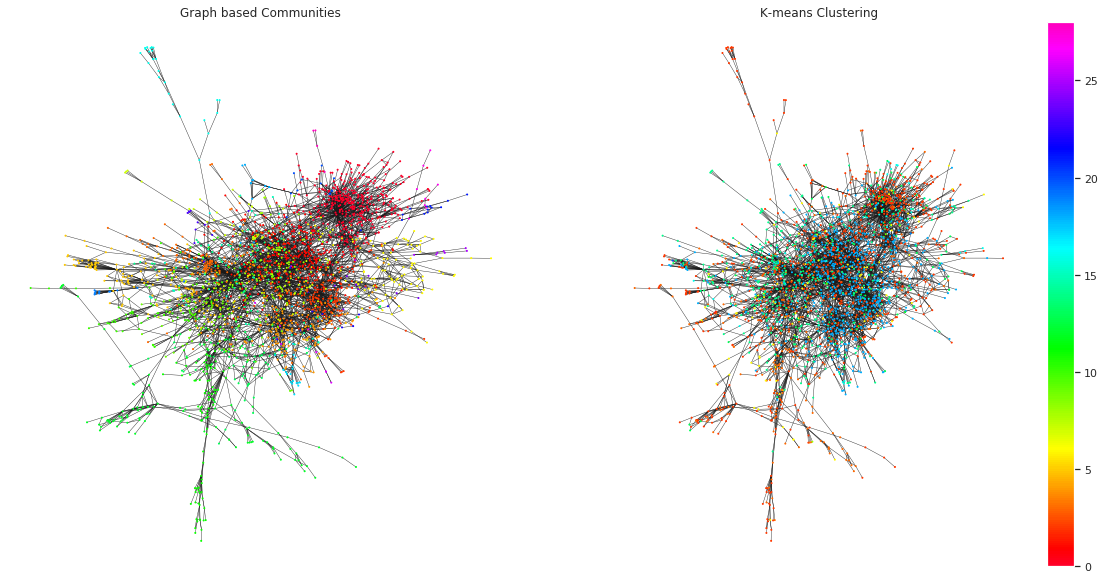

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))


cmap_initial=range(29)
cmap=plt.cm.gist_rainbow
vmin = min(cmap_initial)
vmax = max(cmap_initial)
nx.draw(G,pos,node_size=1, node_color=list(colors_sorted.values()),cmap=cmap, with_labels=False, vmin=vmin, vmax=vmax, ax=ax1, width=0.4)
nx.draw(G,pos,node_size=1, node_color= labels,cmap=cmap, with_labels=False, vmin=vmin, vmax=vmax, ax=ax2, width=0.4)
ax1.set_title('Graph based Communities')
ax2.set_title('K-means Clustering')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)



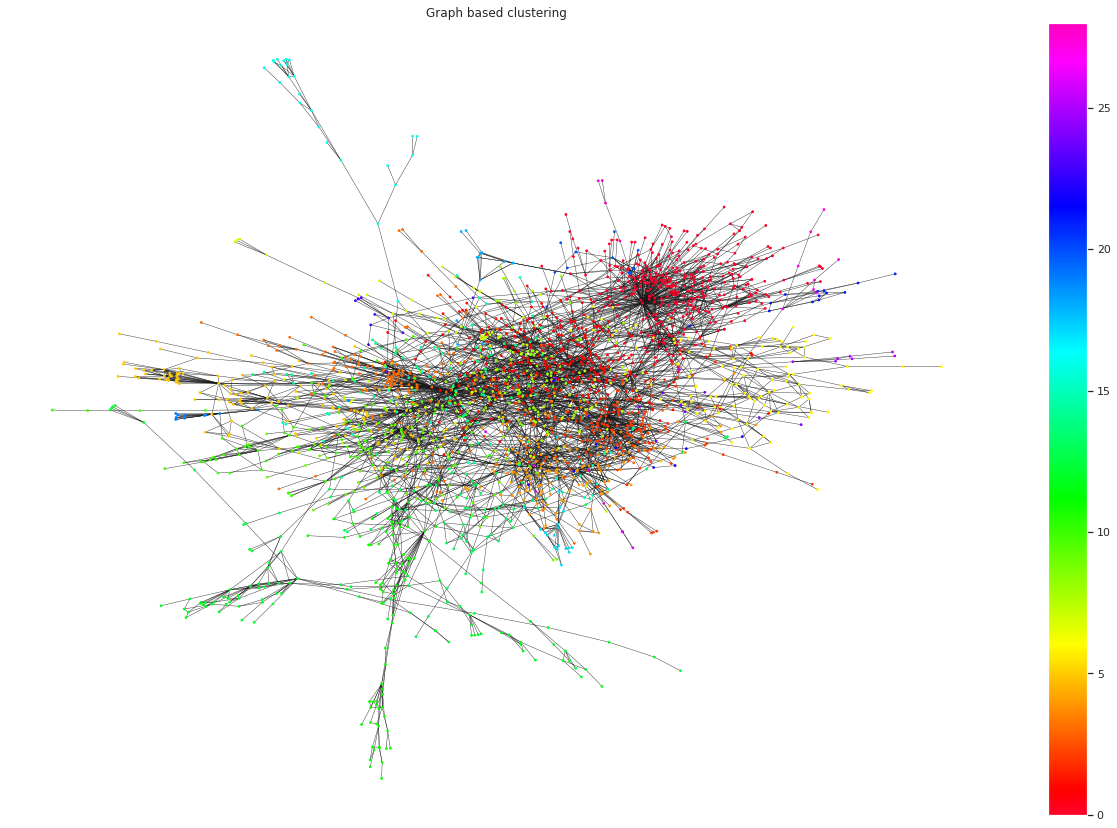

In [ ]:
# plot them individually and larger to get a better insight into the different clusterings
# plot the graph with nodes colored by communities
plt.figure(figsize=(17,11))
cmap_initial=range(29)
cmap=plt.cm.gist_rainbow
vmin = min(cmap_initial)
vmax = max(cmap_initial)
nx.draw(G, pos,node_size=3, node_color=list(colors_sorted.values()), cmap=cmap,
           with_labels=False, vmin=vmin, vmax=vmax, width=0.4)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)
plt.title('Graph based clustering')
plt.show()

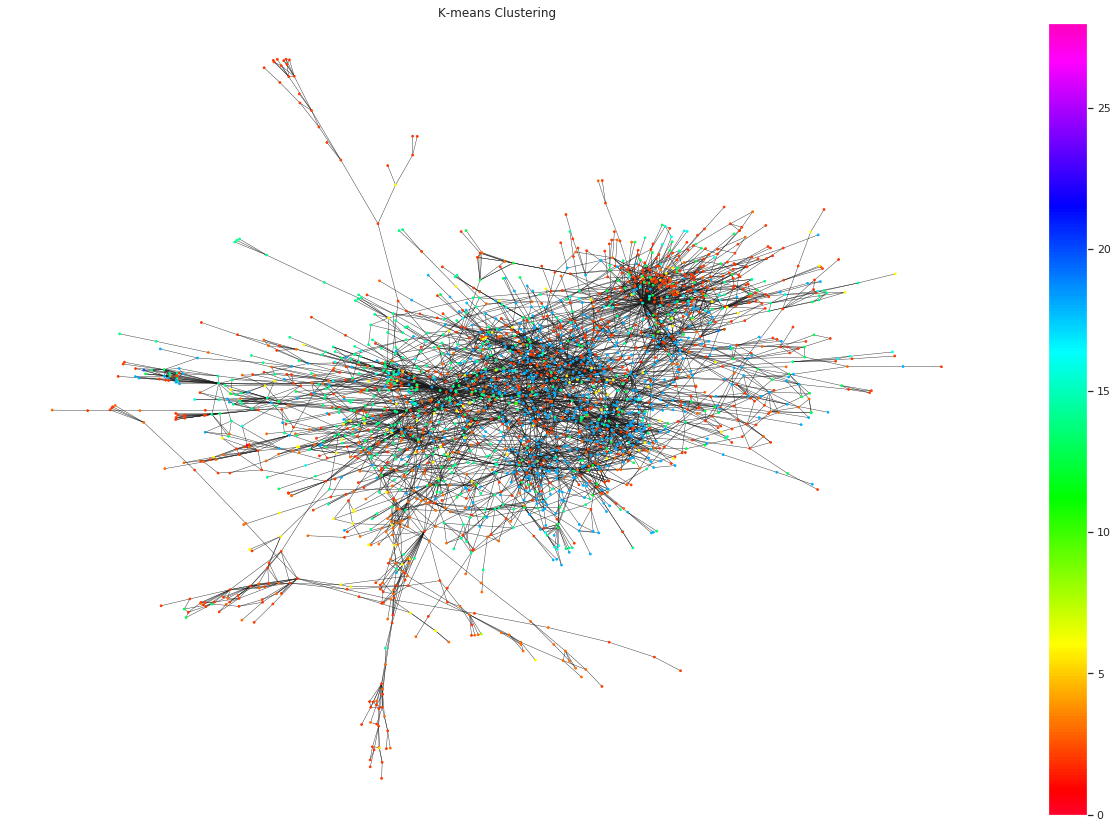

In [ ]:
# plot the graph with nodes colored by communities
plt.figure(figsize=(17,11))
cmap_initial=range(29)
cmap=plt.cm.gist_rainbow
vmin = min(cmap_initial)
vmax = max(cmap_initial)
nx.draw(G, pos,node_size=3, node_color=labels, cmap=cmap,
           with_labels=False, vmin=vmin, vmax=vmax, width=0.4)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)
plt.title('K-means Clustering')
plt.show()

First note that the colors do not match between corresponding communities and clusters, as this would need us to make assumptions about how we would map cluster to community and we would still be left with the problem of having 29 communities and 21 clusters.

Considering the graph with the graph based clusters it is easy to observe that the clusters look not very spread out and like a reasonable partition of the network. This is due to the fact that those communities are computed based on the adjacencies the effect is support by the fact that the graph layout is also influenced by the adjacencies of nodes. In comparison the clustering produced by k-means looks much more spread out across the graph. This is due to the k-means not taking into account the adjacencies but only the feature matrix.

Looking closely we can identify some similarities where clusters and communities seem to have overlap. 

Furthermore, we can observe that the graph with k-means clustering is not 'as colorful' which is caused by the large range of cluster sizes as seen earlier.


Let's apply **PCA** to reduce the data to two dimensions and then visualise the communities and clusters as scatter plots.

In [ ]:
# reducing data to 2-d with PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(feature_mat.values)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf['clusters']=labels
principalDf['communities']= list(colors_sorted.values())
finalDf = principalDf

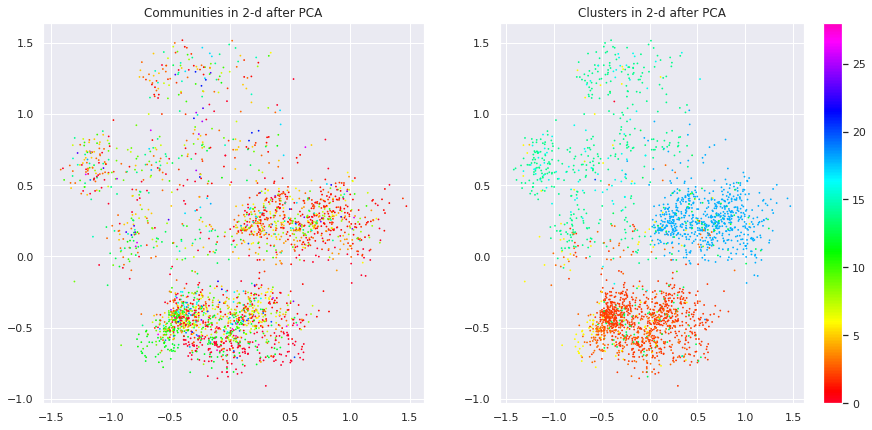

In [ ]:
# plotting reduced data
fig, (ax2,ax1) = plt.subplots(1,2, figsize = (15,7))

cmap_initial=range(29)
cmap=plt.cm.gist_rainbow
vmin = min(cmap_initial)
vmax = max(cmap_initial)
ax1.scatter(finalDf['principal component 1'],finalDf['principal component 2'], c=finalDf['clusters'], cmap=cmap, vmin=vmin, vmax=vmax, zorder=10, s=0.6)
ax1.set_title('Clusters in 2-d after PCA')
ax2.scatter(finalDf['principal component 1'],finalDf['principal component 2'], c=finalDf['communities'], cmap=cmap, vmin=vmin, vmax=vmax, zorder=10, s=0.6)
ax2.set_title('Communities in 2-d after PCA')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)

After dimensionality reduction with PCA the kmeans clustering looks better than the graph based one, with the graph clusters being much more mixed. It is also easy to observe that for the kmeans clustering we have two very big clusters while in the graph based communities there are more communities with medium community size.

Overall, taking into account the contingency matrix, the visualisation of clusters and communities on the graphs and in 2-d, as well as the AMI and ARI scores, we find evidence for a very weak correlation between the feature matrix and the adjacency matrix.